# Volatility Prioritization

## Imports and Function setup

In [13]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import sys
import os
import pyfolio as pf
from pyfolio import timeseries
import matplotlib
import matplotlib.pyplot as plt
import empyrical as ep
import pandas as pd
from scipy import stats
%matplotlib inline

sys.path.append("../")
from FunctionFiles.env.EnvMultipleStock_train import StockEnvTrain
from FunctionFiles.env.EnvMultipleStock_validation import StockEnvValidation
from FunctionFiles.env.EnvMultipleStock_trade import StockEnvTrade
from FunctionFiles.pipeline.training_pipeline import training
from FunctionFiles.pipeline.backtesting_pipeline import backtesting, probabilistic_sharpe_ratio
from FunctionFiles.pipeline.backtesting_pipeline import position_analysis
from Algorithms.VPDDPG.VP_DDPG_V2 import VP_DDPG
from FunctionFiles.env.EnvMultipleStock_trade_pca import StockEnvTradePCA
from FunctionFiles.env.EnvMultipleStock_train_pca import StockEnvTrainPCA
sys.path.append("Experiment 2/")

from stable_baselines.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines import DDPG
from stable_baselines.common.vec_env import DummyVecEnv

plt.rcParams.update({'font.size': 18})

In [10]:
def run_training(data, rebalance_window, validation_window, num_of_runs, model_name, training_function, folder_name, train_env, val_env, trade_env, env_wrapper, turbulence_threshold_level):
    unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()

    for i in range(18, num_of_runs+1):
        tr = training(model_name, train_env, val_env, trade_env, env_wrapper)
        tr.retraining_approach(
            df=data, 
            unique_trade_dates = unique_trade_date,
            rebalance_window = rebalance_window,
            validation_window=validation_window,
            training_instance = f'{folder_name}{i}',
            turbulence_threshold_level = turbulence_threshold_level,
            training_function = training_function
        )

def run_prediction_from_model(data, rebalance_window, validation_window, num_of_runs, model_name, folder_name, train_env, val_env, trade_env, env_wrapper, turbulence_threshold_level, algorithm, model_path):
    unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()

    for i in range(1, num_of_runs+1):
        tr = training(model_name, train_env, val_env, trade_env, env_wrapper)
        tr.predict_from_pretrained(
            df=data, 
            unique_trade_dates = unique_trade_date,
            rebalance_window = rebalance_window,
            validation_window=validation_window,
            training_instance = f'{folder_name}{i}',
            turbulence_threshold_level = turbulence_threshold_level,
            algorithm = algorithm,
            model_path = model_path,
        )

## Temp Graphing Ideas

#### Graphing 

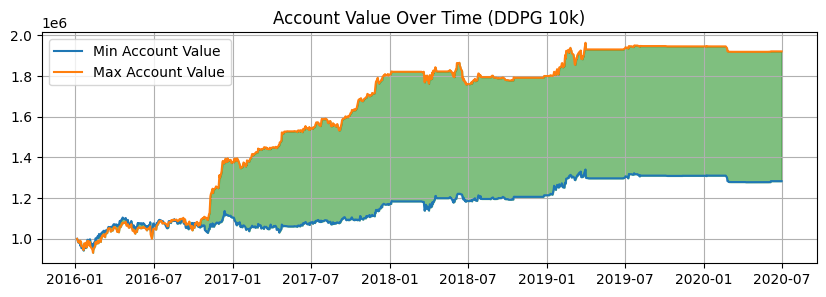

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
ax1.grid()
ax1.set_title(f'Account Value Over Time (DDPG 10k)')

min_data = ddpg.avg_agent.account_value[np.where(ddpg.avg_agent.sharpe == ddpg.avg_agent.sharpe.min())[0][0]]
max_data = ddpg.avg_agent.account_value[np.where(ddpg.avg_agent.sharpe == ddpg.avg_agent.sharpe.max())[0][0]]

x = pd.to_datetime(min_data.dropna().Date)
y_max = max_data.dropna().account_value
y_min = min_data.dropna().account_value
ax1.plot(x, y_min, label = 'Min Account Value')
ax1.plot(x, y_max, label = 'Max Account Value')
ax1.fill_between(x, y_min, y_max, color='green', alpha=0.5)

ax1.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 5))
ax1.grid()
ax1.set_title(f'Account Value Over Time - Algorithm Comparison Graph')

x = pd.to_datetime(ddpg.min_agent.account_value.dropna().Date)
y_max = ddpg.max_agent.account_value.dropna().account_value
y_min = ddpg.min_agent.account_value.dropna().account_value
ax1.plot(x, y_min, label = 'DDPG Min')
ax1.plot(x, y_max, label = 'DDPG Max')
ax1.fill_between(x, y_min, y_max, color='green', alpha=0.2)

x = pd.to_datetime(vpddpg.min_agent.account_value.dropna().Date)
y_max = vpddpg.max_agent.account_value.dropna().account_value
y_min = vpddpg.min_agent.account_value.dropna().account_value
ax1.plot(x, y_min, label = 'VPDDPG Min')
ax1.plot(x, y_max, label = 'VPDDPG Max')
ax1.fill_between(x, y_min, y_max, color='red', alpha=0.2)

ax1.legend()
plt.show()

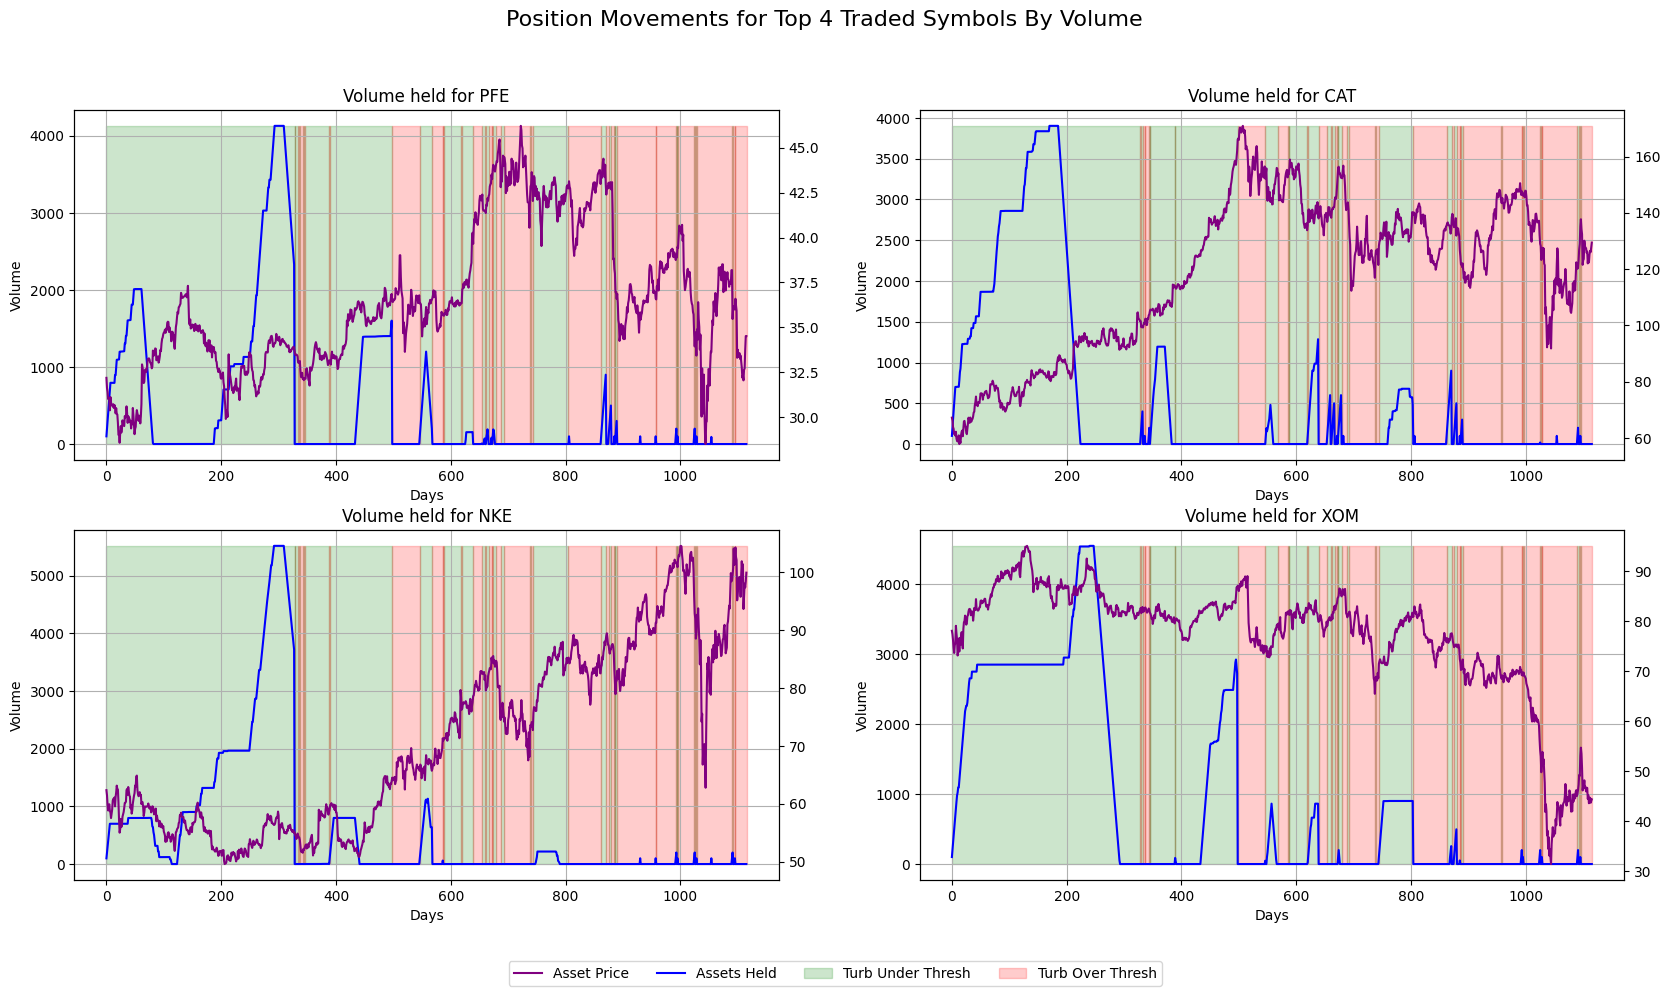

In [6]:
best_iter = np.where(ddpg.avg_agent.sharpe == ddpg.avg_agent.sharpe.max())[0][0]

x = position_analysis(
    model_name = "DDPG_DOW", 
    folder_name = "TurbThresh.90_10K_", 
    iter = best_iter
)
x.load_action_data()

top_volume_indexs = x.get_volume_moved().sort_values().tail(4).index
x.volume_graph_fill_turb(symbols = top_volume_indexs.to_list())

## Volatility Prioritized DDPG

Testing the application of the Volatility Prioritized Replay Buffer to the DDPG algorithm utilizing the 90% data retention PCA results from experiment 1

In [23]:
def train_VPDDPG(env_train, model_name, training_instance, timesteps = 10000):
    """VPDDPG model"""

    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    save_path = f"trained_models/VPDDPG/{training_instance}"
    if not os.path.isdir(save_path): os.mkdir(save_path)

    start = time.time()
    model = VP_DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"trained_models/VPDDPG/{training_instance}/{model_name}")
    print('Training time (VPDDPG): ', (end-start)/60,' minutes')
    return model

def train_VPDDPG_optimized(env_train, model_name, training_instance, timesteps = 1000):
    """VPDDPG model"""

    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    save_path = f"trained_models/VPDDPG/{training_instance}"
    if not os.path.isdir(save_path): os.mkdir(save_path)

    start = time.time()
    model = VP_DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise, gamma=0.9999, batch_size=512, buffer_size=10000)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"trained_models/VPDDPG/{training_instance}/{model_name}")
    print('Training time (VPDDPG): ', (end-start)/60,' minutes')
    return model

In [ ]:
preprocessed_path = "../Data/done_data_pca90.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

run_training(
    data = data,
    rebalance_window = 63, 
    validation_window = 63, 
    num_of_runs = 20,
    model_name = "VPDDPG_DOW", 
    training_function = train_VPDDPG_optimized,
    folder_name = "pca90_", 
    train_env = StockEnvTrainPCA, 
    val_env = StockEnvValidation,
    trade_env = StockEnvTradePCA,
    env_wrapper = DummyVecEnv,
    turbulence_threshold_level = 0.90
)

### Testing

In [5]:
print('VPDDPG')
vpddpg = backtesting(
    model_name = [
        "VPDDPG_DOW_pca90_1", "VPDDPG_DOW_pca90_2", "VPDDPG_DOW_pca90_3", "VPDDPG_DOW_pca90_4", "VPDDPG_DOW_pca90_5",
        "VPDDPG_DOW_pca90_6", "VPDDPG_DOW_pca90_7", "VPDDPG_DOW_pca90_8", "VPDDPG_DOW_pca90_9", "VPDDPG_DOW_pca90_10",
        "VPDDPG_DOW_pca90_11", "VPDDPG_DOW_pca90_12", "VPDDPG_DOW_pca90_13", "VPDDPG_DOW_pca90_14", "VPDDPG_DOW_pca90_15",
        "VPDDPG_DOW_pca90_16", "VPDDPG_DOW_pca90_17", "VPDDPG_DOW_pca90_18", "VPDDPG_DOW_pca90_19", "VPDDPG_DOW_pca90_20",
    ],
)

VPDDPG
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.118917    0.115362
Cumulative Return   0.659621    0.634471
Annual Volatility   0.0841211   0.0851329
Sharpe Ratio        1.37797     1.33613
Sortino Ratio       2.12936     2.05902
Max Drawdown       -0.0719745  -0.0721062
Sharpe STD: 0.10785770577762495


## Comparing Results

DDPG vs VPDDPG vs TD3 vs VPTD3

In [12]:
print('DDPG PCA .90')
ddpg90 = backtesting(
    model_name = [
        "DDPG_90_pca90_1", "DDPG_90_pca90_2", "DDPG_90_pca90_3", "DDPG_90_pca90_4", "DDPG_90_pca90_5",
        "DDPG_90_pca90_6", "DDPG_90_pca90_7", "DDPG_90_pca90_8", "DDPG_90_pca90_9", "DDPG_90_pca90_10",
        "DDPG_90_pca90_11", "DDPG_90_pca90_12", "DDPG_90_pca90_13", "DDPG_90_pca90_14", "DDPG_90_pca90_15",
        "DDPG_90_pca90_16", "DDPG_90_pca90_17", "DDPG_90_pca90_18", "DDPG_90_pca90_19", "DDPG_90_pca90_20"
    ],
    file_path = '../Experiment 0/working_files/account_value_trade_{}_{}.csv'
)

print('\nVPDDPG')
vpddpg = backtesting(
    model_name = [
        "VPDDPG_DOW_pca90_1", "VPDDPG_DOW_pca90_2", "VPDDPG_DOW_pca90_3", "VPDDPG_DOW_pca90_4", "VPDDPG_DOW_pca90_5",
        "VPDDPG_DOW_pca90_6", "VPDDPG_DOW_pca90_7", "VPDDPG_DOW_pca90_8", "VPDDPG_DOW_pca90_9", "VPDDPG_DOW_pca90_10",
        "VPDDPG_DOW_pca90_11", "VPDDPG_DOW_pca90_12", "VPDDPG_DOW_pca90_13", "VPDDPG_DOW_pca90_14", "VPDDPG_DOW_pca90_15",
        "VPDDPG_DOW_pca90_16", "VPDDPG_DOW_pca90_17", "VPDDPG_DOW_pca90_18", "VPDDPG_DOW_pca90_19", "VPDDPG_DOW_pca90_20",
    ],
)

print('\nTD3')
td3 = backtesting(
    model_name = [
        "TD3_DOW_pca90_1", "TD3_DOW_pca90_2", "TD3_DOW_pca90_3", "TD3_DOW_pca90_4", "TD3_DOW_pca90_5", 
        "TD3_DOW_pca90_6", "TD3_DOW_pca90_7", "TD3_DOW_pca90_8", "TD3_DOW_pca90_9", "TD3_DOW_pca90_10", 
        "TD3_DOW_pca90_11", "TD3_DOW_pca90_12", "TD3_DOW_pca90_13", "TD3_DOW_Base_10k_14", "TD3_DOW_pca90_15",
        "TD3_DOW_pca90_16", "TD3_DOW_pca90_17", "TD3_DOW_pca90_18", "TD3_DOW_Base_10k_19", "TD3_DOW_pca90_20"
    ],
    file_path = '../Experiment 2/working_files/account_value_trade_{}_{}.csv'
)

print('\nVPTD3')
vptd3 = backtesting(
    model_name = [
        "VPTD3_DOW_pca90_1", "VPTD3_DOW_pca90_2", "VPTD3_DOW_pca90_3", "VPTD3_DOW_pca90_4", "VPTD3_DOW_pca90_5", 
        "VPTD3_DOW_pca90_6", "VPTD3_DOW_pca90_7", "VPTD3_DOW_pca90_8", "VPTD3_DOW_pca90_9", "VPTD3_DOW_pca90_10", 
        "VPTD3_DOW_pca90_11", "VPTD3_DOW_pca90_12", "VPTD3_DOW_pca90_13", "VPTD3_DOW_Base_10k_14", "VPTD3_DOW_pca90_15",
        "VPTD3_DOW_pca90_16", "VPTD3_DOW_pca90_17", "VPTD3_DOW_pca90_18", "VPTD3_DOW_Base_10k_19", "VPTD3_DOW_pca90_20"
    ],
    file_path = '../Experiment 2/working_files/account_value_trade_{}_{}.csv'
)

DDPG PCA .90
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.11175     0.108319
Cumulative Return   0.61405     0.588534
Annual Volatility   0.0825361   0.0818388
Sharpe Ratio        1.3276      1.27703
Sortino Ratio       2.05314     1.93821
Max Drawdown       -0.0694947  -0.0683058
Sharpe STD: 0.21271731029752788

VPDDPG
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.118917    0.115362
Cumulative Return   0.659621    0.634471
Annual Volatility   0.0841211   0.0851329
Sharpe Ratio        1.37797     1.33613
Sortino Ratio       2.12936     2.05902
Max Drawdown       -0.0719745  -0.0721062
Sharpe STD: 0.10785770577762495

TD3
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.114471    0.110935
Cumulative Return   0.631421    0.605459
Annual Volatility   0.0839395   0.0844997
Sharpe Ratio        1.33595     1.33308
So

In [33]:
perf_stats_all = timeseries.perf_stats(
    returns=vptd3.benchmark(),
    positions=None,
    transactions=None,
    turnover_denom="AGB",
)

perf_stats_all

Annual return          0.095396
Cumulative returns     0.505217
Annual volatility      0.205182
Sharpe ratio           0.547857
Calmar ratio           0.257228
Stability              0.772906
Max drawdown          -0.370862
Omega ratio            1.131817
Sortino ratio          0.749768
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.844303
Daily value at risk   -0.025404
dtype: float64

### T-Test Results

In [9]:
p_value = stats.ttest_ind(ddpg90.avg_agent.sharpe, vptd3.avg_agent.sharpe, equal_var = False).pvalue
print(f"P-Value: {round(p_value, 5)}, %: {round(p_value*100, 2)}")

P-Value: 0.03189, %: 3.19


### Wil Coxon Results

In [11]:
p_value = stats.wilcoxon(ddpg90.avg_agent.sharpe, vptd3.avg_agent.sharpe, alternative='less').pvalue
print(f"P-Value: {round(p_value, 5)}, %: {round(p_value*100, 2)}")

P-Value: 0.02658, %: 2.66


In [14]:
def _get_account_value_retraining(model_name, rebalance_window, validation_window, unique_trade_date, path = 'working_files/account_value_trade_{}_{}.csv'):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv(path.format(i, model_name)) 
        df_account_value = pd.concat([df_account_value, temp])
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    df_account_value = df_account_value.reset_index(drop=True)
    df_account_value=df_account_value.join(pd.DataFrame({'datadate':unique_trade_date})[63:].reset_index(drop=True))
    df_account_value['daily_return']=df_account_value.account_value.pct_change(1)
    return df_account_value

def min_max_performance_graph(algorithm_data, mid_run_index, title):
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))
    ax1.grid()
    ax1.set_title(title)

    min_data = algorithm_data.avg_agent.account_value[np.where(algorithm_data.avg_agent.sharpe == algorithm_data.avg_agent.sharpe.min())[0][0]]
    max_data = algorithm_data.avg_agent.account_value[np.where(algorithm_data.avg_agent.sharpe == algorithm_data.avg_agent.sharpe.max())[0][0]]
    mid_data = algorithm_data.avg_agent.account_value[mid_run_index]

    x = pd.to_datetime(min_data.dropna().Date)
    y_max = max_data.dropna().account_value
    y_min = min_data.dropna().account_value
    y_mid = mid_data.dropna().account_value
    ax1.plot(x, y_min, label = 'Min Account Value')
    ax1.plot(x, y_max, label = 'Max Account Value')
    ax1.plot(x, y_mid, label = 'Median Account Value', color = "purple")
    ax1.fill_between(x, y_min, y_max, color='green', alpha=0.2)

    dji = pd.read_csv("../data/^DJI.csv")
    test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-07-06')]
    test_dji = test_dji.reset_index(drop=True)
    test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)
    test_dji["cum_returns"] = ep.cum_returns(test_dji.daily_return, 1.0)*1000000
    ax1.plot(pd.to_datetime(test_dji.Date), test_dji.cum_returns, label = "DJIA Account Value", color="Black")

    ax1.legend()
    plt.show()

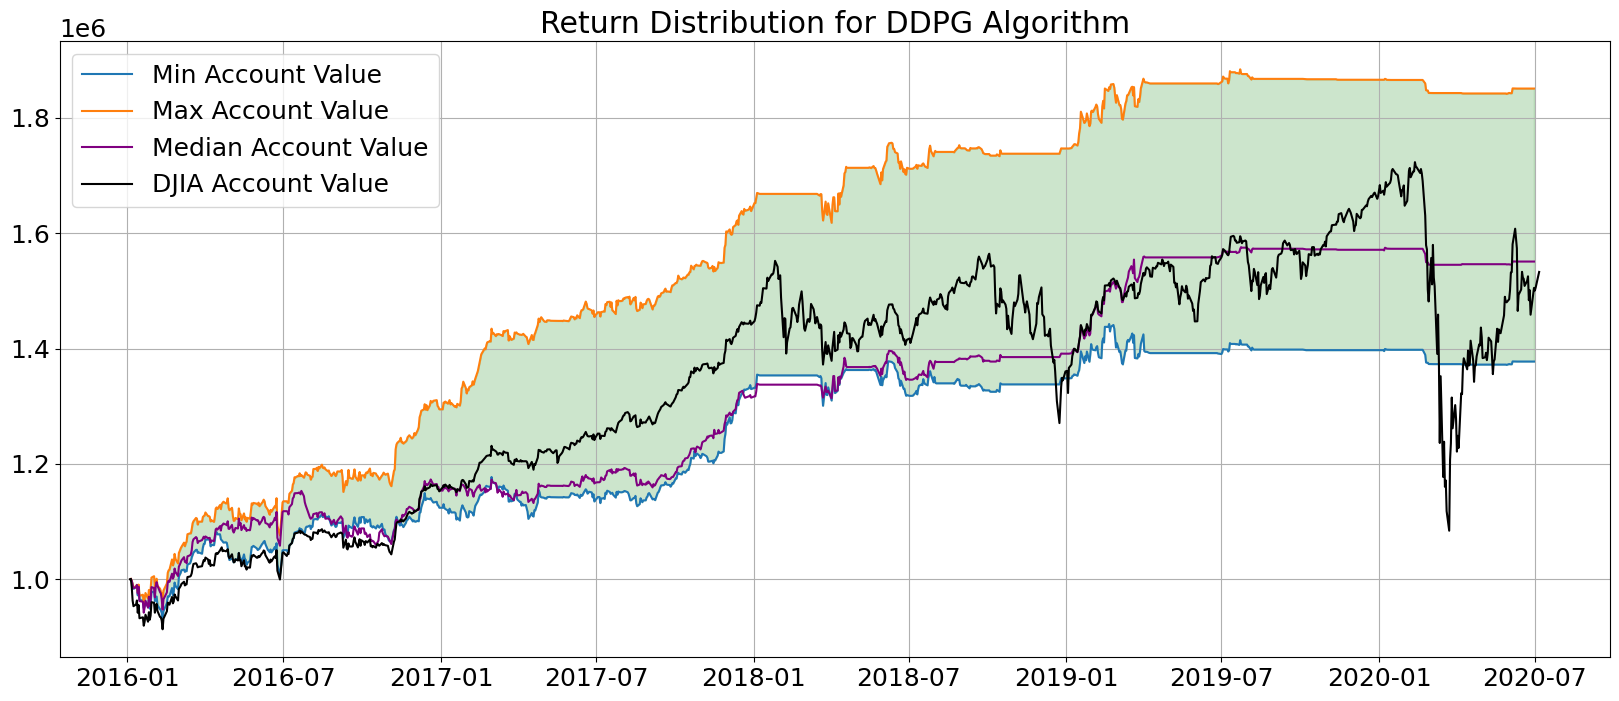

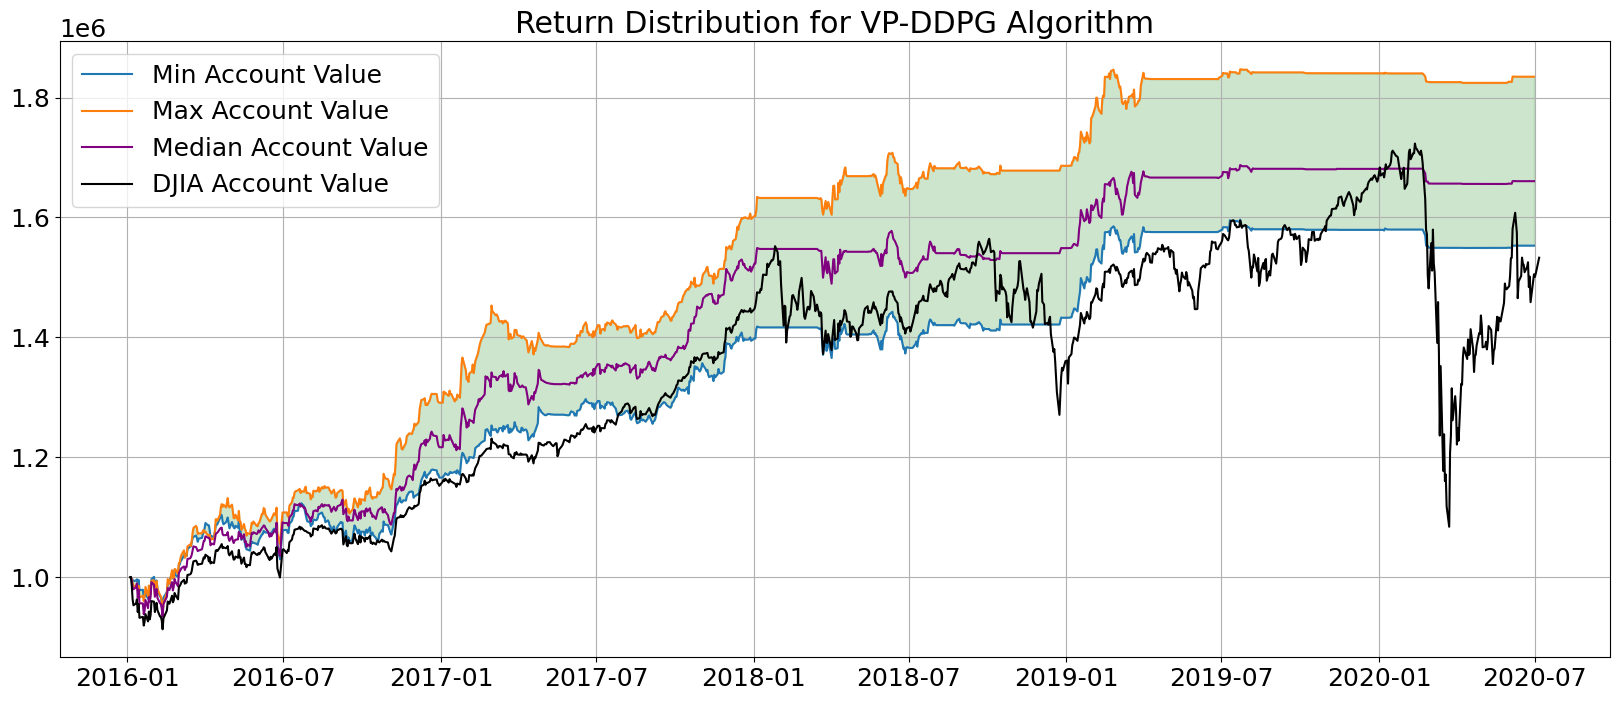

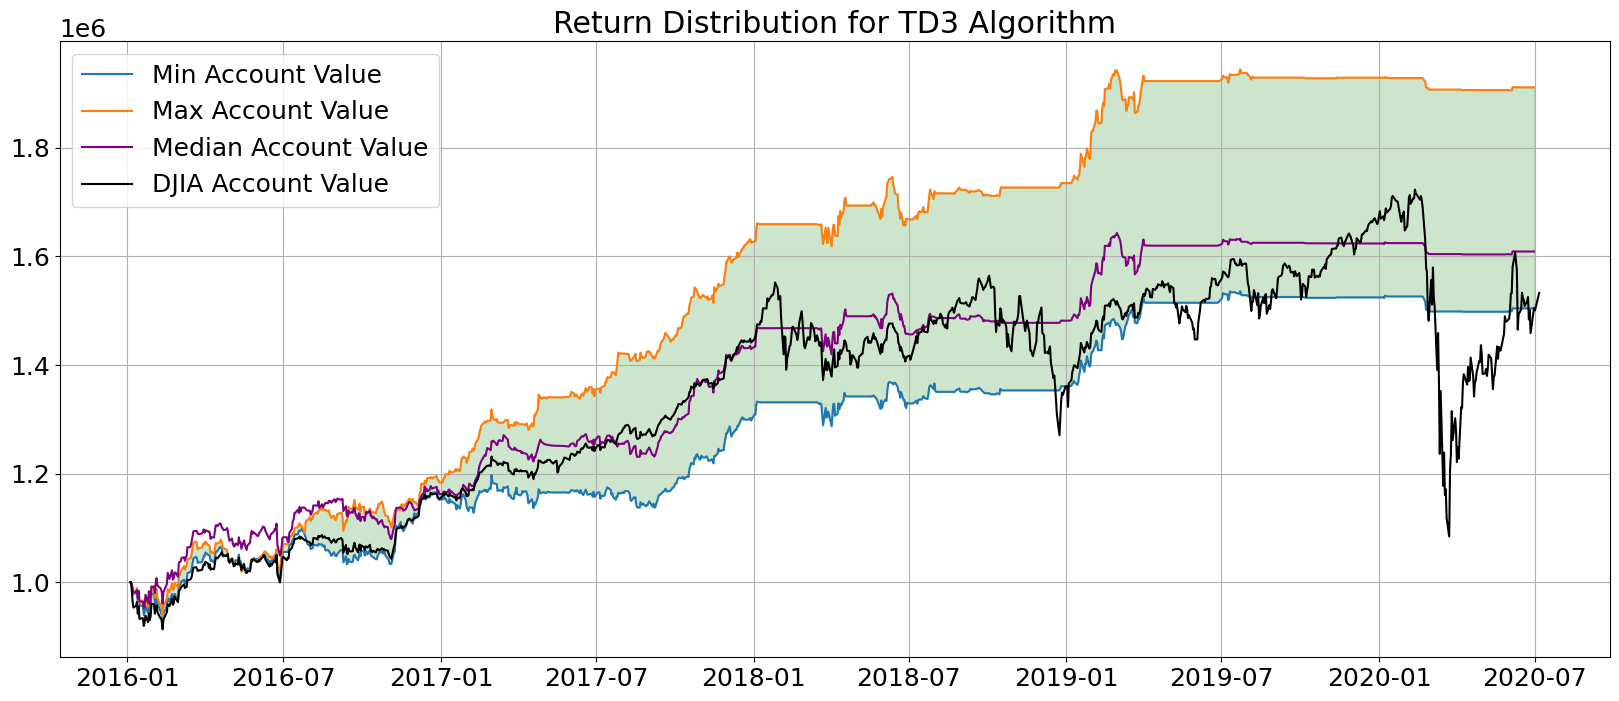

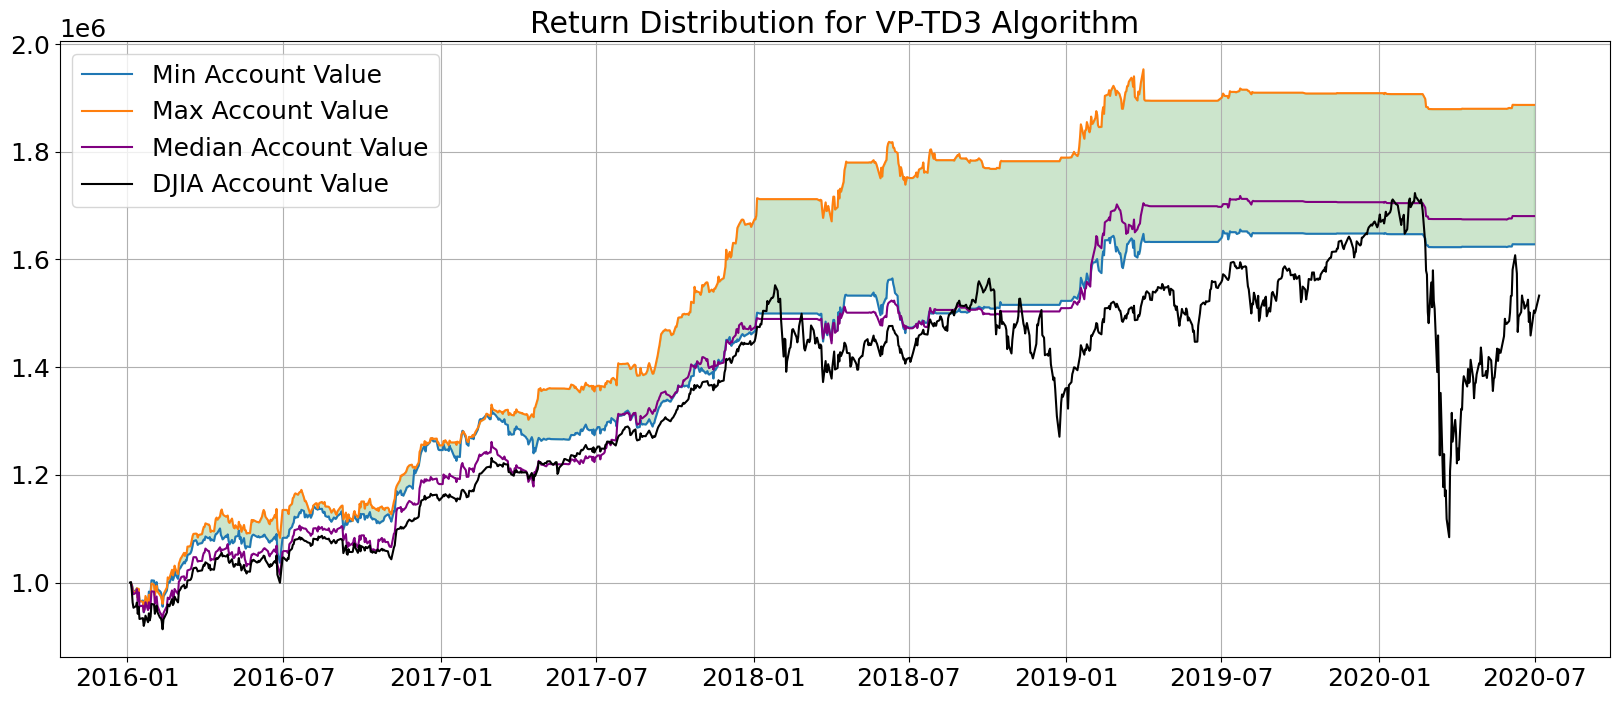

In [15]:
plt.rcParams.update({'font.size': 18})
min_max_performance_graph(ddpg90, 6, "Return Distribution for DDPG Algorithm")
min_max_performance_graph(vpddpg, 18, "Return Distribution for VP-DDPG Algorithm")
min_max_performance_graph(td3, 5, "Return Distribution for TD3 Algorithm")
min_max_performance_graph(vptd3, 5, "Return Distribution for VP-TD3 Algorithm")

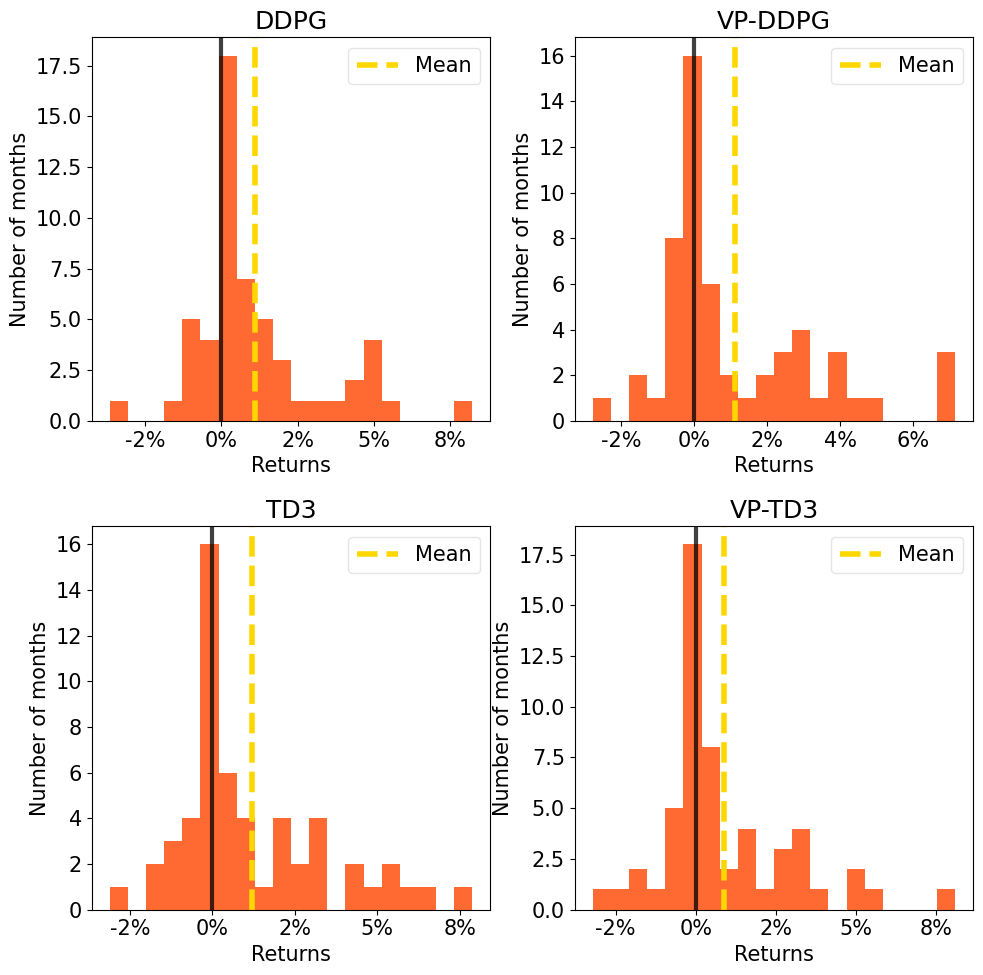

In [22]:
preprocessed_path = "../Data/done_data_pca90.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()
fig = plt.figure(1)

ad = _get_account_value_retraining("DDPG_90_pca90_16", 63, 63, unique_trade_date, path = '../Experiment 0/working_files/account_value_trade_{}_{}.csv') 
ad['Date'] = pd.to_datetime(ad['datadate'], format = "%Y%m%d")
ad.set_index('Date', drop = True, inplace = True)
ad.index = ad.index.tz_localize('UTC')
ddpg_res = pd.Series(ad['daily_return'].values, index=ad.index)
ax1 = plt.subplot(2,2,1)
pf.plot_monthly_returns_dist(ddpg_res)
ax1.title.set_text('DDPG')

ad = _get_account_value_retraining("VPDDPG_DOW_pca90_15", 63, 63, unique_trade_date)
ad['Date'] = pd.to_datetime(ad['datadate'], format = "%Y%m%d")
ad.set_index('Date', drop = True, inplace = True)
ad.index = ad.index.tz_localize('UTC')
vpddpg_res = pd.Series(ad['daily_return'].values, index=ad.index)
ax2 = plt.subplot(2,2,2)
pf.plot_monthly_returns_dist(vpddpg_res)
ax2.title.set_text('VP-DDPG')

ad = _get_account_value_retraining("TD3_DOW_pca90_15", 63, 63, unique_trade_date, path = '../Experiment 2/working_files/account_value_trade_{}_{}.csv')
ad['Date'] = pd.to_datetime(ad['datadate'], format = "%Y%m%d")
ad.set_index('Date', drop = True, inplace = True)
ad.index = ad.index.tz_localize('UTC')
td3_res = pd.Series(ad['daily_return'].values, index=ad.index)
ax3 = plt.subplot(2,2,3)
pf.plot_monthly_returns_dist(td3_res)
ax3.title.set_text('TD3')

ad = _get_account_value_retraining("TD3_DOW_pca90_13", 63, 63, unique_trade_date, path = '../Experiment 2/working_files/account_value_trade_{}_{}.csv')
ad['Date'] = pd.to_datetime(ad['datadate'], format = "%Y%m%d")
ad.set_index('Date', drop = True, inplace = True)
ad.index = ad.index.tz_localize('UTC')
vptd3_res = pd.Series(ad['daily_return'].values, index=ad.index)
ax4 = plt.subplot(2,2,4)
pf.plot_monthly_returns_dist(vptd3_res)
ax4.title.set_text('VP-TD3')

plt.rcParams.update({'font.size': 15})
plt.tight_layout()
fig.set_size_inches(10,10)
fig.tight_layout() 

plt.show()


In [1]:
best_iter_td3 = np.where(td3.avg_agent.sharpe == td3.avg_agent.sharpe.max())[0][0]
best_iter_vptd3 = np.where(vptd3.avg_agent.sharpe == vptd3.avg_agent.sharpe.max())[0][0]

x = position_analysis(
    model_name = "TD4_DOW", 
    folder_name = "pca90_", 
    iter = best_iter
)
x.load_action_data()
top_volume_indexs = x.get_volume_moved().sort_values().index

i = 0
while i < len(top_volume_indexs):
    x.volume_graph_fill_turb(symbols = top_volume_indexs[i:i+4].to_list())
    i = i+4

NameError: name 'np' is not defined